# Enhanced Spectrogram Visualization
**Topic**: FITS data visualization, Gaussian smoothing, time-frequency analysis

In this notebook, we'll:
- Read a CALLISTO FITS file
- Visualize the spectrogram in dB
- Apply Gaussian smoothing
- Zoom in on specific time and frequency ranges
- Format time in human-readable form (hh:mm:ss)


##  Step 1: Import required libraries

In [1]:
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from scipy.ndimage import gaussian_filter
import pylab as mplot

## Step 2: Define a helper function for smoothing

In [2]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    return np.convolve(y, box, mode='same')

##  Step 3: Load FITS data and convert to dB

In [3]:
# Define your local directory and filename (replace with your own file path)
mypath = r"C:\Users\VivoBook\OneDrive\Desktop\python"  # Use raw string (r'') to avoid escape issues
myfile = 'BIR_20150311_161500_02.fit.gz'
# Combine into full path
full_path = os.path.join(mypath, myfile) 

fmin, fmax = 100.0, 190.0  # MHz
tmin, tmax = '16:20:00', '16:30:00'  # UT

# Load FITS file
hdu = fits.open(full_path)
print(hdu.info())

# Convert raw data to dB
data = hdu[0].data.astype(np.float32) / 255.0 * 2500.0 / 25.4
background = np.min(data)
data_dB = data - background

# Load frequency and time arrays
freqs = hdu[1].data['Frequency'][0]
time_rel = hdu[1].data['Time'][0]
hdu.close()

Filename: C:\Users\VivoBook\OneDrive\Desktop\python\BIR_20150311_161500_02.fit.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (3600, 200)   uint8   
  1                1 BinTableHDU     16   1R x 2C   [3600D8.3, 200D8.3]   
None


## Step 4: Plot raw spectrogram

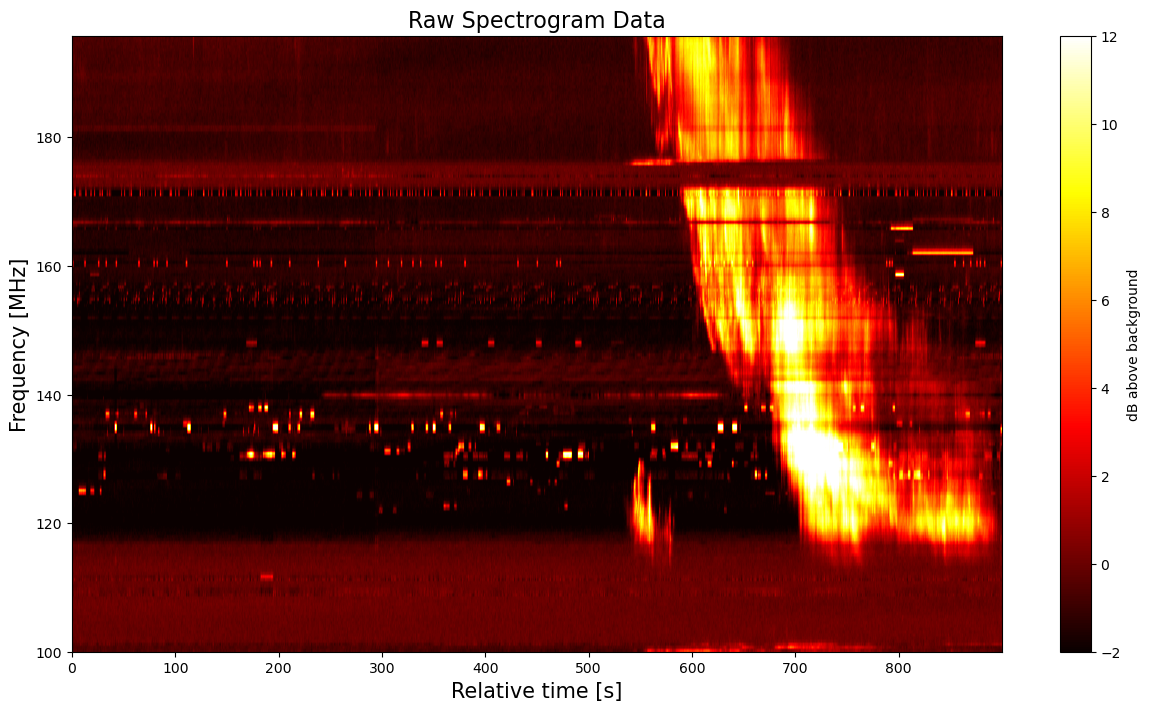

In [4]:
extent = (time_rel[0], time_rel[-1], freqs[-1], freqs[0])
data_dB -= data_dB.mean(axis=1, keepdims=True)
data_dB = data_dB.clip(-2, 12)

plt.figure(figsize=(15, 8))
plt.imshow(data_dB, aspect='auto', extent=extent, cmap=cm.hot)
plt.xlabel('Relative time [s]', fontsize=15)
plt.ylabel('Frequency [MHz]', fontsize=15)
plt.title('Raw Spectrogram Data', fontsize=16)
plt.colorbar(label='dB above background')
plt.show()

##  Step 5: Apply Gaussian smoothing and zoom in

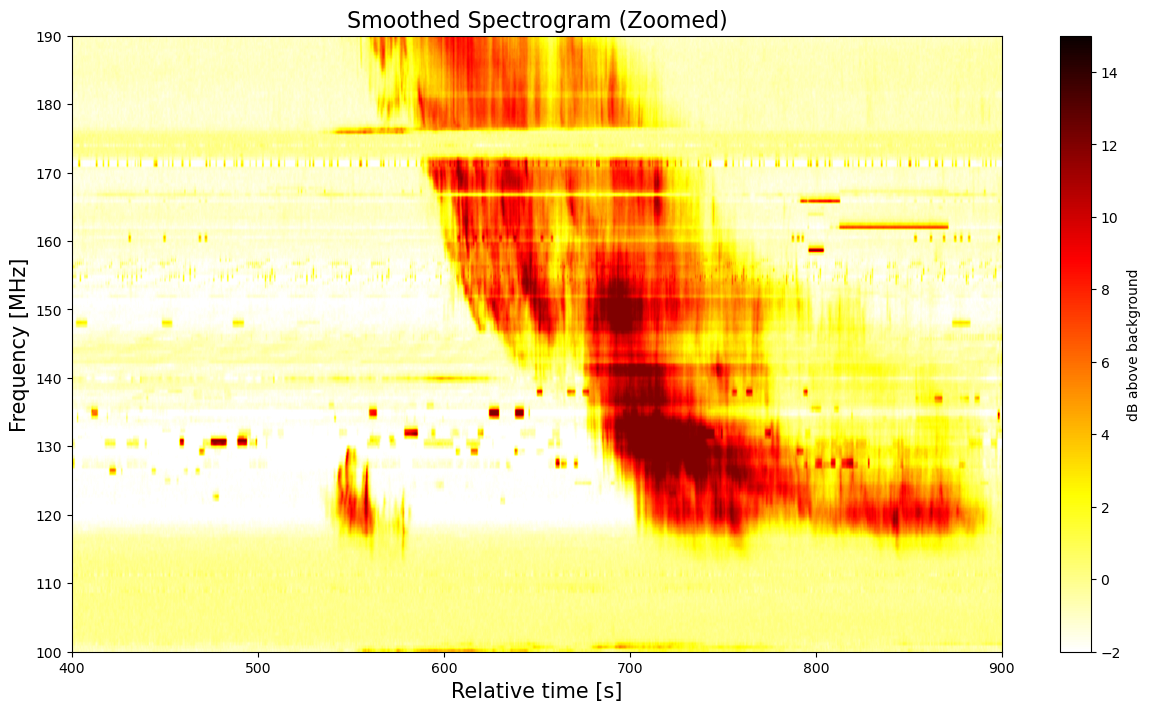

In [5]:
sigma = [0, 1]
smoothed = gaussian_filter(data_dB, sigma)

plt.figure(figsize=(15, 8))
plt.imshow(smoothed, aspect='auto', extent=extent, cmap=cm.hot_r,
           norm=plt.Normalize(vmin=-2, vmax=15))
plt.xlim((400, 900))
plt.ylim((fmin, fmax))
plt.xlabel('Relative time [s]', fontsize=15)
plt.ylabel('Frequency [MHz]', fontsize=15)
plt.title('Smoothed Spectrogram (Zoomed)', fontsize=16)
plt.colorbar(label='dB above background')
plt.show()

## Step 6: Plot with real time axis (hh:mm:ss)

C:\Users\VivoBook\AppData\Local\Temp\ipykernel_20428\214314363.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yt_labels, fontsize=14)


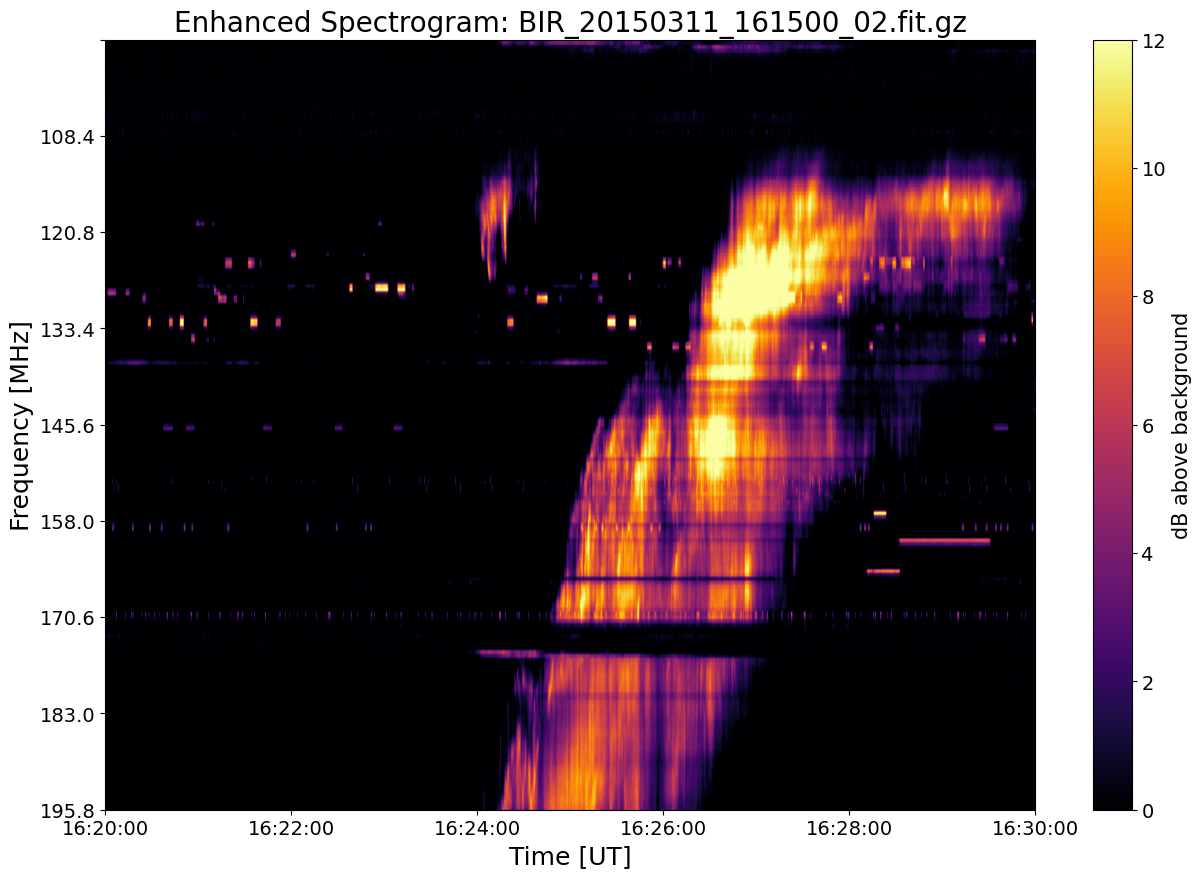

In [6]:
# Get start time in UT seconds
header = fits.getheader(full_path)
hh, mm, ss = map(float, header['TIME-OBS'].split(':'))
start_ut_sec = hh * 3600 + mm * 60 + ss
ut_time = time_rel + start_ut_sec

def time_to_sec(t):
    h, m, s = map(int, t.split(':'))
    return h * 3600 + m * 60 + s

tmin_sec = time_to_sec(tmin) - ut_time[0]
tmax_sec = time_to_sec(tmax) - ut_time[0]
dt = header['CDELT1']
xmin = (tmin_sec + 1.0) / dt
xmax = (tmax_sec + 1.0) / dt

klow = np.searchsorted(freqs, fmin, side='left')
khigh = np.searchsorted(freqs, fmax, side='right')

fig, ax = mplot.subplots(figsize=(15, 10))
mplot.imshow(smoothed, aspect='auto', cmap=cm.inferno,
             norm=plt.Normalize(vmin=0, vmax=12))
mplot.axis([xmin, xmax, klow, khigh])

# Format x-axis ticks
xticks = np.linspace(xmin, xmax, 6)
xt_labels = []
for idx in xticks:
    ut_sec = ut_time[int(idx)] if int(idx) < len(ut_time) else ut_time[-1]
    h = int(ut_sec // 3600)
    m = int((ut_sec % 3600) // 60)
    s = int(ut_sec % 60)
    xt_labels.append(f'{h:02d}:{m:02d}:{s:02d}')
ax.set_xticks(xticks)
ax.set_xticklabels(xt_labels, fontsize=14)

yticks = ax.get_yticks()
yt_labels = [f'{freqs[int(y)]:.1f}' if 0 <= int(y) < len(freqs) else '' for y in yticks]
ax.set_yticklabels(yt_labels, fontsize=14)

mplot.xlabel('Time [UT]', fontsize=18)
mplot.ylabel('Frequency [MHz]', fontsize=18)
mplot.title(f'Enhanced Spectrogram: {myfile}', fontsize=20)
cb = mplot.colorbar(ax.images[0])
cb.set_label('dB above background', fontsize=15)
cb.ax.tick_params(labelsize=14)
plt.show()